In [75]:
'''General Libraries'''
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 500)

'''Statistic'''
import scipy
from scipy import stats
from scipy.stats import norm
import datetime

'''Scikit Learn'''
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV

from sklearn.cluster import KMeans, OPTICS 
from sklearn.metrics import silhouette_samples, silhouette_score

'''Ploting Libraries'''
from plotly.offline import iplot, plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = "iframe" 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style 
style.use("fivethirtyeight") 

import seaborn as sns
sns.set_palette('RdBu')

import warnings
warnings.filterwarnings("ignore")

import yellowbrick

'''Miscellaneous'''

'''Seeds'''
import random
random.seed(10)
np.random.seed(11)

# Introducing

After all of clustering work in previous notebook, we finally cluster observations into groups with respective labels. 

To hand over our clustering results to business, we firstly call clusters by the words ***'personas'*** from now on. Next, we will try to find out ***characteristics*** of those personas.

In this notebook:  
* First, I will visualize those personas in 3 aspects: ***Gender, Ranges of Ages, and Ranges of Paces***.  
* Second, I am introducing those personas in words.

# The Best Clustering

Here are Silhouette scores of clustering algorithms:  
* K-means      -- k = 5 : 0.74
* K_prototypes -- k = 5 : -0.05
* OPTICS       -- k = 3 : 0.69

The answer are clear, the winner is K-means clustering. So, hereby we will be building personas and characteristic based on K-means results. 

# The Dataset

In [76]:
df1 = pd.read_csv('data_Cleaned.csv')
df2 = pd.read_csv('clusterLabel_kmeans_5.csv')

df = pd.concat([df1, df2], axis=1)

In [77]:
df

,name,5k,10k,20k,half,25k,30k,35k,40k,official,pace,rank_overall,rank_in_gender_only,rank_in_division,age,gender,country,state,city,bib,cluster
0,"Yamamoto, Hiroyuki",8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25,3.27,8,8,8,47,M,JPN,others,Fukuoka,W1,3
1,"Jeptoo, Rita",16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,5.30,21,1,1,33,F,KEN,others,Eldoret,F1,0
2,"Van Dyk, Ernst F.",7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,3.08,1,1,1,41,M,RSA,others,Paarl,W2,3
3,"Dibaba, Mare",16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,5.37,27,3,3,24,F,ETH,others,Shoa,F2,0
4,"Hokinoue, Kota",8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,3.10,2,2,2,40,M,JPN,others,Nogata Fukuoka,W3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31629,"Anderson, Steve K.",26.13,50.72,99.55,104.78,124.02,148.65,174.90,200.22,211.75,8.08,9849,7500,3414,32,M,USA,CA,Larkspur,35908,1
31630,"McCarthy, Michael P.",31.07,61.28,128.37,135.85,165.02,203.43,244.70,285.47,302.52,11.55,27456,15459,5212,34,M,USA,MA,Norwell,35909,1
31631,"Brimmer, Delia C.",28.18,59.00,123.33,130.57,157.02,192.65,229.62,266.30,282.00,10.77,25092,10788,5231,21,F,USA,CT,West Simsbury,35910,2
31632,"Morganthal, Amy",30.98,63.75,129.90,137.03,167.82,207.52,247.18,285.87,302.73,11.55,27476,12009,5800,38,F,USA,MA,North Andover,35911,2


In [78]:
df.cluster.value_counts()

1    14333
2    12596
3     1905
0     1565
4     1235
Name: cluster, dtype: int64

In [79]:
n_cluster = 5

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


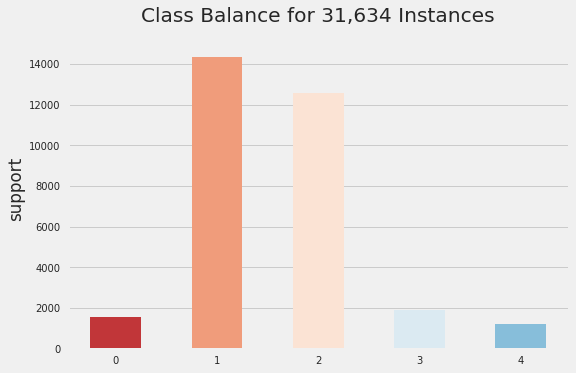

In [80]:
# Class balance of Clusters
from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=range(n_cluster))
visualizer.fit(df['cluster'])
visualizer.show()   

# Data Preparing for Analysis

## Adding a Column: 'age_ranges'

In [81]:
# Define age_ranges
def age_to_age_ranges(age):
    if age<=34             : return 0
    if (35<=age)&(age<=44) : return 1
    if age>=45             : return 2
    
age_ranges = df['age'].apply(age_to_age_ranges)

df.insert(15, 'age_ranges', value=age_ranges)

## Adding a Column: 'pace_ranges'

In [82]:
# Define age_ranges
def pace_to_pace_ranges(pace):
    if pace<=8.4             : return 0
    if (9<=pace)&(pace<=9.3)  : return 1
    if pace>=9.4             : return 2
    
pace_ranges = df['pace'].apply(pace_to_pace_ranges)

df.insert(11, 'pace_ranges', value=pace_ranges)

In [83]:
df.head()

,name,5k,10k,20k,half,25k,30k,35k,40k,official,pace,pace_ranges,rank_overall,rank_in_gender_only,rank_in_division,age,age_ranges,gender,country,state,city,bib,cluster
0,"Yamamoto, Hiroyuki",8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25,3.27,0.0,8,8,8,47,2,M,JPN,others,Fukuoka,W1,3
1,"Jeptoo, Rita",16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,5.30,0.0,21,1,1,33,0,F,KEN,others,Eldoret,F1,0
2,"Van Dyk, Ernst F.",7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,3.08,0.0,1,1,1,41,1,M,RSA,others,Paarl,W2,3
3,"Dibaba, Mare",16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,5.37,0.0,27,3,3,24,0,F,ETH,others,Shoa,F2,0
4,"Hokinoue, Kota",8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,3.10,0.0,2,2,2,40,1,M,JPN,others,Nogata Fukuoka,W3,3


# Visualization

## Each Cluster One DataFrame

In [84]:
# Using Python dict
cluster_data = {}

for i in range(n_cluster):
    index = str(i)
    cluster_data['cluster_'+index] = df[df.cluster==i]

print(list(cluster_data.keys()))

['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4']


## Gender 

In [85]:
# Gender of clusters

## The data, used to visualization
cluster_gender = {}
for i in range(n_cluster):
    index = str(i)
    cluster_gender['cluster_'+index] = cluster_data['cluster_'+index].gender.value_counts()

## To DataFrame
cluster_gender = pd.DataFrame(cluster_gender).T
cluster_gender.fillna(0, inplace=True)

## Print
cluster_gender

,F,M
cluster_0,1565.0,0.0
cluster_1,0.0,14333.0
cluster_2,12596.0,0.0
cluster_3,0.0,1905.0
cluster_4,0.0,1235.0


In [86]:
# Gender of clusters
fig = go.Figure()

# Labels of X-axis
x = ['Cluster ' +str(i) for i in range(n_cluster)]

# The core
fig.add_bar(name='Female',x=x, y=cluster_gender.iloc[:, 0], marker_color='pink')
fig.add_bar(name='Male'  ,x=x, y=cluster_gender.iloc[:, 1], marker_color='blue')

# Layout
fig.update_layout(barmode='group',
                  title='Clusters - Gender')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

## Ranges of Age

In [87]:
# Age of clusters: 

## The data: absolute number
cluster_age_ranges = {}
for i in range(n_cluster):
    index = str(i)
    cluster_age_ranges['cluster_'+index] = cluster_data['cluster_'+index]['age_ranges'].value_counts()

## To DataFrame
cluster_age_ranges = pd.DataFrame(cluster_age_ranges).T
cluster_age_ranges.fillna(0, inplace=True)

## Print
cluster_age_ranges

,0,1,2
cluster_0,259,468,838
cluster_1,3481,3870,6982
cluster_2,4571,3905,4120
cluster_3,203,571,1131
cluster_4,111,285,839


In [88]:
# Age of clusters: 

## The data: absolute number 
age_ranges_percent = cluster_age_ranges.copy()
age_ranges_percent['sum'] = age_ranges_percent.sum(axis=1)

for i in range(3):
    age_ranges_percent.iloc[:, i] = age_ranges_percent.iloc[:, i] / age_ranges_percent['sum']

age_ranges_percent.drop('sum', axis=1, inplace=True)
age_ranges_percent

,0,1,2
cluster_0,0.165495,0.299042,0.535463
cluster_1,0.242866,0.270006,0.487128
cluster_2,0.362893,0.310019,0.327088
cluster_3,0.106562,0.299738,0.593701
cluster_4,0.089879,0.230769,0.679352


In [89]:
# Ages of clusters
fig = go.Figure()

# Labesl of X-axis
x = ['Cluster ' +str(i) for i in range(n_cluster)]

# The core
fig.add_bar(name='Young' ,x=x, y=cluster_age_ranges.iloc[:, 0], marker_color='green')
fig.add_bar(name='Midle' ,x=x, y=cluster_age_ranges.iloc[:, 1], marker_color='blue')
fig.add_bar(name='Old'   ,x=x, y=cluster_age_ranges.iloc[:, 2], marker_color='red')

# Layout
fig.update_layout(barmode='group',
                  title='Clusters - Ages -- Absolute numbers')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [90]:
# Ages of clusters
fig = go.Figure()

# Labesl of X-axis
x = ['Cluster ' +str(i) for i in range(n_cluster)]

# The core
fig.add_bar(name='Young' ,x=x, y=age_ranges_percent.iloc[:, 0], marker_color='green')
fig.add_bar(name='Midle' ,x=x, y=age_ranges_percent.iloc[:, 1], marker_color='blue')
fig.add_bar(name='Old'   ,x=x, y=age_ranges_percent.iloc[:, 2], marker_color='red')

# Layout
fig.update_layout(barmode='group',
                  title='Clusters - Ages -- Percentages')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

## Ranges of Paces

In [91]:
# Paces of clusters: 

## The data: absolute number
cluster_pace_ranges = {}
for i in range(n_cluster):
    index = str(i)
    cluster_pace_ranges['cluster_'+index] = cluster_data['cluster_'+index]['pace_ranges'].value_counts()

## To DataFrame
cluster_pace_ranges = pd.DataFrame(cluster_pace_ranges).T
cluster_pace_ranges.fillna(0, inplace=True)

## Print
cluster_pace_ranges

,0.0,1.0,2.0
cluster_0,446,148,605
cluster_1,7026,671,4993
cluster_2,3280,995,5951
cluster_3,1008,111,561
cluster_4,753,70,240


In [92]:
# Paces of clusters: 

## The data: absolute number 
pace_ranges_percent = cluster_pace_ranges.copy()
pace_ranges_percent['sum'] = pace_ranges_percent.sum(axis=1)

for i in range(3):
    pace_ranges_percent.iloc[:, i] = pace_ranges_percent.iloc[:, i] / pace_ranges_percent['sum']

pace_ranges_percent.drop('sum', axis=1, inplace=True)
pace_ranges_percent

,0.0,1.0,2.0
cluster_0,0.371977,0.123436,0.504587
cluster_1,0.553664,0.052876,0.393459
cluster_2,0.320751,0.097301,0.581948
cluster_3,0.600000,0.066071,0.333929
cluster_4,0.708373,0.065851,0.225776


In [93]:
# Paces of clusters
fig = go.Figure()

# Labesl of X-axis
x = ['Cluster ' +str(i) for i in range(n_cluster)]

# The core
fig.add_bar(name='Slow' ,x=x, y=cluster_pace_ranges.iloc[:, 0], marker_color='green')
fig.add_bar(name='Midle' ,x=x, y=cluster_pace_ranges.iloc[:, 1], marker_color='blue')
fig.add_bar(name='Fast'   ,x=x, y=cluster_pace_ranges.iloc[:, 2], marker_color='red')

# Layout
fig.update_layout(barmode='group',
                  title='Clusters - Paces -- Absolute numbers')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [94]:
# Paces of clusters
fig = go.Figure()

# Labesl of X-axis
x = ['Cluster ' +str(i) for i in range(n_cluster)]

# The core
fig.add_bar(name='Slow' ,x=x, y=pace_ranges_percent.iloc[:, 0], marker_color='green')
fig.add_bar(name='Midle' ,x=x, y=pace_ranges_percent.iloc[:, 1], marker_color='blue')
fig.add_bar(name='Fast'   ,x=x, y=pace_ranges_percent.iloc[:, 2], marker_color='red')

# Layout
fig.update_layout(barmode='group',
                  title='Clusters - Paces -- Percentages')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

# Verbose Brief of Personas

*Please refer to the file Personas--Charactersitics.xlsx in the same folder of this notebook, which was prepare to support this part.*

***Persona 1 - The Winners***  
He is classified as the ***cluster 4***. He is one of the oldest men in the marathon. He is a man, of course. He comes from ***CAN***, in his ***late 40***, or even older, over 53. He runs pretty ***slow*** in comparing to others if not the lowest, but somehow he still get ***higher ranks*** in the overall ranking, as well as in female-ranking or in his own division ranking.

I have to say, he is a miracle.

***Persona 2 - The Fastest Elder Woman***  
She is at the ***cluster 0***. She is just a minority in the whole, but she is a star. She doesn't come from USA, but ***CAN or other*** countries. Despite of her ***higher age***, her pace even be ***faster*** than men at any ages. She is not the winner in the overall ranking, but be the ***winner in gender*** of female and the ***second in her own division***.

A non-USA woman, she gains my respect.

***Personas 3 - The Youngest but Worst***  
She is in the ***cluster 2***. She is one of stereotype of this data with proportion of ***40%*** in total data points. She comes from ***USA*** like most of others. She runs ***faster*** than even men competitors in the marathan, but tradically her rank is ***moreoften worse or worst*** in all ranking table.  

A sad story.

***Personas 4 - The Average***
He is in the ***cluster 1***. Again, we have an ***USA man*** here. And again, he appears in almost ***50%*** in our dataset. He runs at a ***slow*** pace and get ***very normal*** results in every division. Nothing much to say about him. 

He just a man in very other men.